In [1]:
import torch
torch.__version__

'0.4.0'

https://github.com/adambielski/siamese-triplet

377 stars

In [2]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [4]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

## Common setup

In [5]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [6]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [7]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.376108	Accuracy: 11.328125
Train: [12800/60000 (21%)]	Loss: 3.067357	Accuracy: 10.416666666666666
Train: [25600/60000 (43%)]	Loss: 2.309083	Accuracy: 9.622524752475247
Train: [38400/60000 (64%)]	Loss: 2.226172	Accuracy: 10.72019867549669
Train: [51200/60000 (85%)]	Loss: 1.789786	Accuracy: 15.770755597014926
Epoch: 1/20. Train set: Average loss: 2.1833	Accuracy: 21.833333333333332
Epoch: 1/20. Validation set: Average loss: 1.0124	Accuracy: 65.85
Train: [0/60000 (0%)]	Loss: 1.096410	Accuracy: 58.203125
Train: [12800/60000 (21%)]	Loss: 0.857894	Accuracy: 77.08333333333333
Train: [25600/60000 (43%)]	Loss: 0.639078	Accuracy: 82.99427599009901
Train: [38400/60000 (64%)]	Loss: 0.521070	Accuracy: 85.76158940397352
Train: [51200/60000 (85%)]	Loss: 0.429952	Accuracy: 87.5174906716418
Epoch: 2/20. Train set: Average loss: 0.5776	Accuracy: 88.42
Epoch: 2/20. Validation set: Average loss: 0.2829	Accuracy: 94.88
Train: [0/60000 (0%)]	Loss: 0.199857	Accuracy: 97.265625
T

Train: [38400/60000 (64%)]	Loss: 0.011835	Accuracy: 99.77235099337749
Train: [51200/60000 (85%)]	Loss: 0.011388	Accuracy: 99.78428171641791
Epoch: 18/20. Train set: Average loss: 0.0135	Accuracy: 99.765
Epoch: 18/20. Validation set: Average loss: 0.1653	Accuracy: 98.77
Train: [0/60000 (0%)]	Loss: 0.007965	Accuracy: 99.609375
Train: [12800/60000 (21%)]	Loss: 0.010743	Accuracy: 99.82383578431373
Train: [25600/60000 (43%)]	Loss: 0.011958	Accuracy: 99.81048886138613
Train: [38400/60000 (64%)]	Loss: 0.014631	Accuracy: 99.79304635761589
Train: [51200/60000 (85%)]	Loss: 0.014840	Accuracy: 99.78039490049751
Epoch: 19/20. Train set: Average loss: 0.0127	Accuracy: 99.78166666666667
Epoch: 19/20. Validation set: Average loss: 0.1679	Accuracy: 98.78
Train: [0/60000 (0%)]	Loss: 0.004266	Accuracy: 100.0
Train: [12800/60000 (21%)]	Loss: 0.009094	Accuracy: 99.86213235294117
Train: [25600/60000 (43%)]	Loss: 0.014500	Accuracy: 99.79501856435644
Train: [38400/60000 (64%)]	Loss: 0.012860	Accuracy: 99.7930

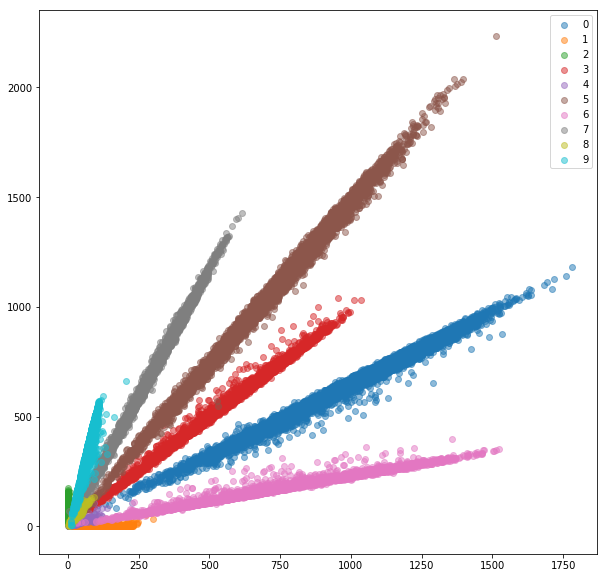

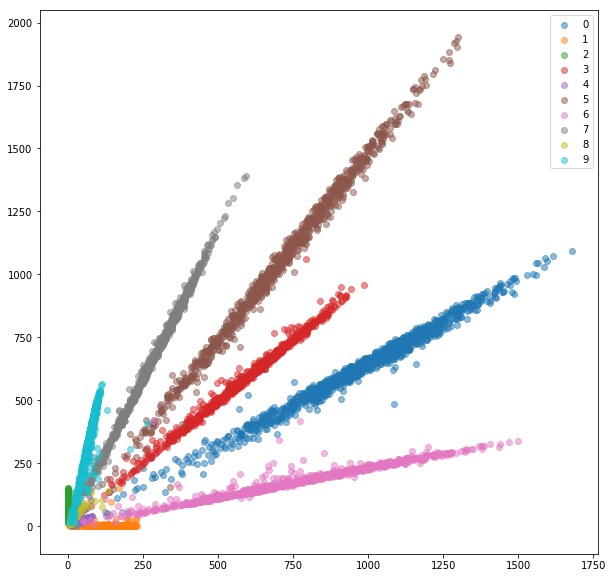

In [8]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [9]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [10]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.204810
Train: [12800/60000 (21%)]	Loss: 0.069037
Train: [25600/60000 (43%)]	Loss: 0.041022
Train: [38400/60000 (64%)]	Loss: 0.028761
Train: [51200/60000 (85%)]	Loss: 0.023577
Epoch: 1/20. Train set: Average loss: 0.0379
Epoch: 1/20. Validation set: Average loss: 0.0169
Train: [0/60000 (0%)]	Loss: 0.016805
Train: [12800/60000 (21%)]	Loss: 0.017417
Train: [25600/60000 (43%)]	Loss: 0.013674
Train: [38400/60000 (64%)]	Loss: 0.012503
Train: [51200/60000 (85%)]	Loss: 0.012121
Epoch: 2/20. Train set: Average loss: 0.0136
Epoch: 2/20. Validation set: Average loss: 0.0111
Train: [0/60000 (0%)]	Loss: 0.007061
Train: [12800/60000 (21%)]	Loss: 0.009498
Train: [25600/60000 (43%)]	Loss: 0.009013
Train: [38400/60000 (64%)]	Loss: 0.008008
Train: [51200/60000 (85%)]	Loss: 0.008336
Epoch: 3/20. Train set: Average loss: 0.0087
Epoch: 3/20. Validation set: Average loss: 0.0081
Train: [0/60000 (0%)]	Loss: 0.008162
Train: [12800/60000 (21%)]	Loss: 0.007067
Train: [25600/60000 (

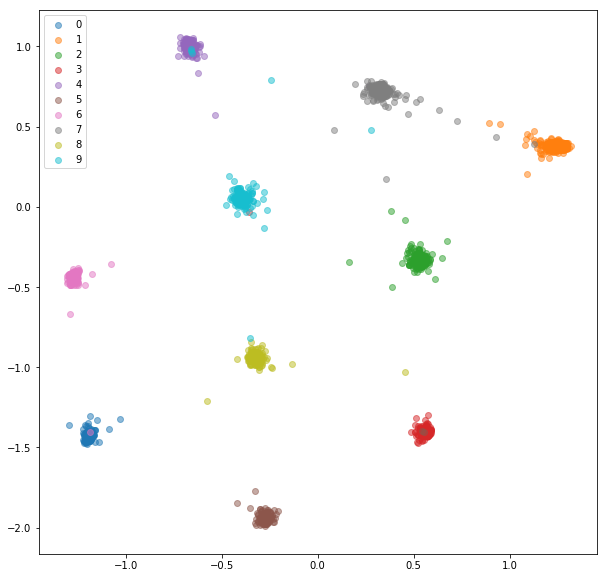

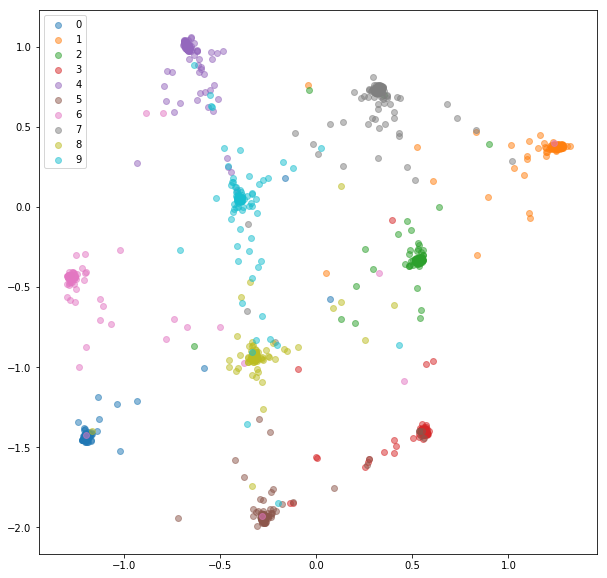

In [11]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [12]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [13]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999507
Train: [12800/60000 (21%)]	Loss: 0.308941
Train: [25600/60000 (43%)]	Loss: 0.163958
Train: [38400/60000 (64%)]	Loss: 0.101620
Train: [51200/60000 (85%)]	Loss: 0.080777
Epoch: 1/20. Train set: Average loss: 0.1508
Epoch: 1/20. Validation set: Average loss: 0.0599
Train: [0/60000 (0%)]	Loss: 0.056589
Train: [12800/60000 (21%)]	Loss: 0.055471
Train: [25600/60000 (43%)]	Loss: 0.050041
Train: [38400/60000 (64%)]	Loss: 0.040612
Train: [51200/60000 (85%)]	Loss: 0.047338
Epoch: 2/20. Train set: Average loss: 0.0467
Epoch: 2/20. Validation set: Average loss: 0.0496
Train: [0/60000 (0%)]	Loss: 0.007444
Train: [12800/60000 (21%)]	Loss: 0.036256
Train: [25600/60000 (43%)]	Loss: 0.038624
Train: [38400/60000 (64%)]	Loss: 0.041004
Train: [51200/60000 (85%)]	Loss: 0.034602
Epoch: 3/20. Train set: Average loss: 0.0365
Epoch: 3/20. Validation set: Average loss: 0.0364
Train: [0/60000 (0%)]	Loss: 0.024998
Train: [12800/60000 (21%)]	Loss: 0.023791
Train: [25600/60000 (

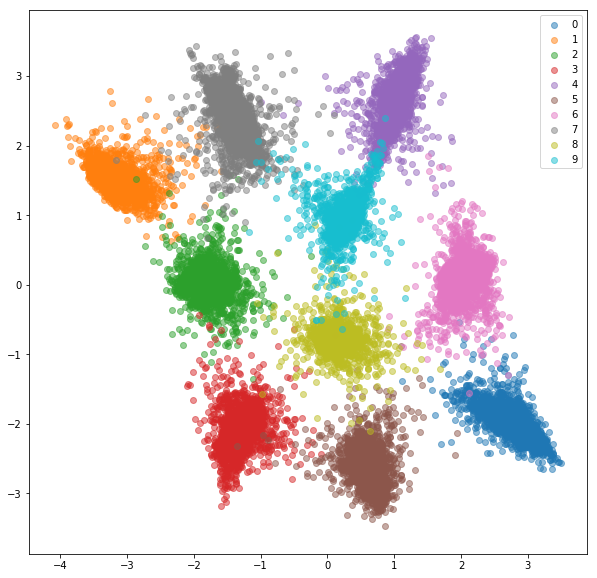

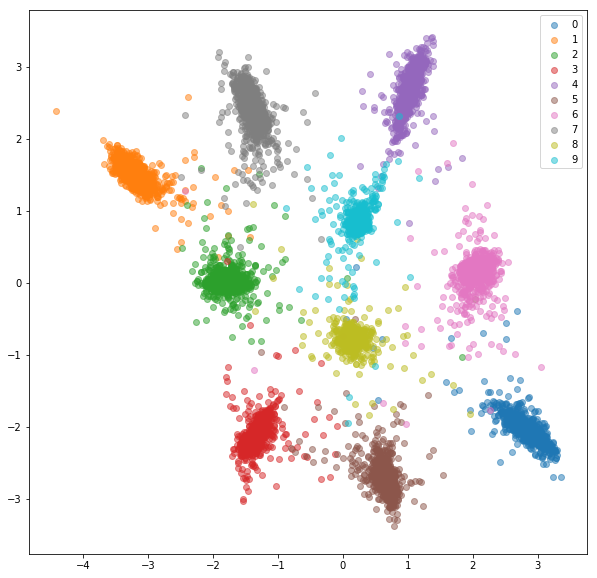

In [14]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection

In [15]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [16]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.491775
Train: [12500/60000 (21%)]	Loss: 0.269943
Train: [25000/60000 (42%)]	Loss: 0.135923
Train: [37500/60000 (62%)]	Loss: 0.094640
Train: [50000/60000 (83%)]	Loss: 0.070188
Epoch: 1/20. Train set: Average loss: 0.1306
Epoch: 1/20. Validation set: Average loss: 0.0507
Train: [0/60000 (0%)]	Loss: 0.055822
Train: [12500/60000 (21%)]	Loss: 0.050863
Train: [25000/60000 (42%)]	Loss: 0.046041
Train: [37500/60000 (62%)]	Loss: 0.037781
Train: [50000/60000 (83%)]	Loss: 0.040708
Epoch: 2/20. Train set: Average loss: 0.0427
Epoch: 2/20. Validation set: Average loss: 0.0311
Train: [0/60000 (0%)]	Loss: 0.028843
Train: [12500/60000 (21%)]	Loss: 0.029221
Train: [25000/60000 (42%)]	Loss: 0.026104
Train: [37500/60000 (62%)]	Loss: 0.028118
Train: [50000/60000 (83%)]	Loss: 0.027365
Epoch: 3/20. Train set: Average loss: 0.0271
Epoch: 3/20. Validation set: Average loss: 0.0339
Train: [0/60000 (0%)]	Loss: 0.048413
Train: [12500/60000 (21%)]	Loss: 0.020983
Train: [25000/60000 (

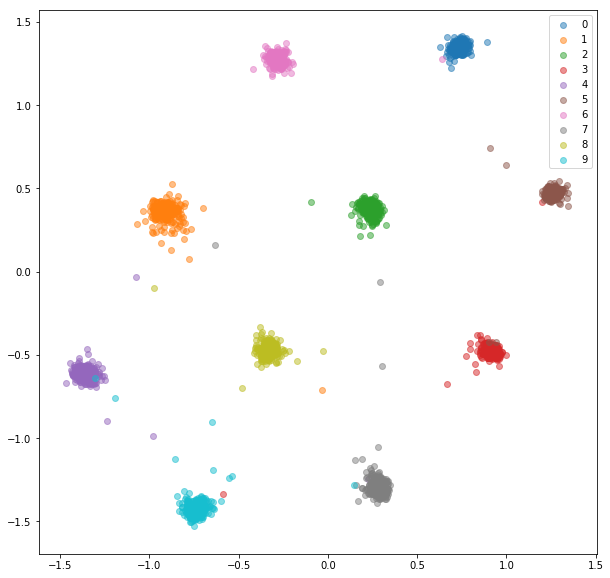

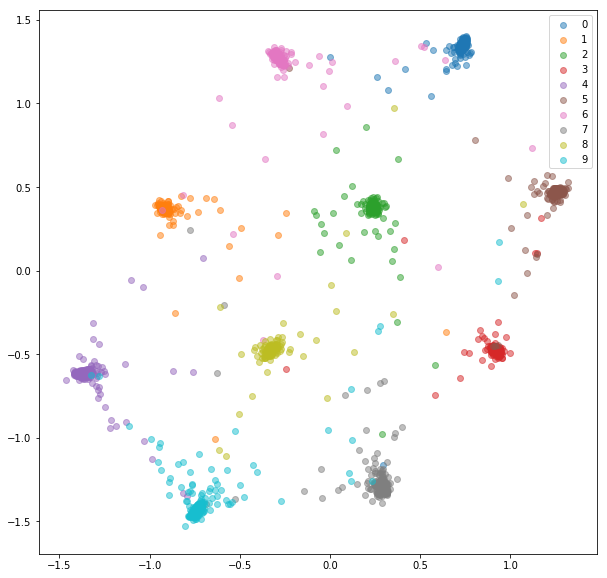

In [17]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection

In [18]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [19]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999661	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.988496	Average nonzero triplets: 2632.0392156862745
Train: [25000/60000 (42%)]	Loss: 0.961383	Average nonzero triplets: 2274.910891089109
Train: [37500/60000 (62%)]	Loss: 0.989286	Average nonzero triplets: 2023.046357615894
Train: [50000/60000 (83%)]	Loss: 0.991185	Average nonzero triplets: 1855.9751243781095
Epoch: 1/20. Train set: Average loss: 0.9803	Average nonzero triplets: 1744.2719665271966
Epoch: 1/20. Validation set: Average loss: 0.8756	Average nonzero triplets: 910.0
Train: [0/60000 (0%)]	Loss: 0.562487	Average nonzero triplets: 863.0
Train: [12500/60000 (21%)]	Loss: 1.030133	Average nonzero triplets: 971.0392156862745
Train: [25000/60000 (42%)]	Loss: 0.962496	Average nonzero triplets: 907.950495049505
Train: [37500/60000 (62%)]	Loss: 1.043436	Average nonzero triplets: 899.9072847682119
Train: [50000/60000 (83%)]	Loss: 1.035043	Average nonzero triplets: 857.592039800995
E

Train: [0/60000 (0%)]	Loss: 0.000000	Average nonzero triplets: 1.0
Train: [12500/60000 (21%)]	Loss: 0.255119	Average nonzero triplets: 41.15686274509804
Train: [25000/60000 (42%)]	Loss: 0.204953	Average nonzero triplets: 33.37623762376238
Train: [37500/60000 (62%)]	Loss: 0.297417	Average nonzero triplets: 33.75496688741722
Train: [50000/60000 (83%)]	Loss: 0.184844	Average nonzero triplets: 36.86069651741293
Epoch: 15/20. Train set: Average loss: 0.2576	Average nonzero triplets: 39.89958158995816
Epoch: 15/20. Validation set: Average loss: 1.0343	Average nonzero triplets: 310.5128205128205
Train: [0/60000 (0%)]	Loss: 0.088261	Average nonzero triplets: 6.0
Train: [12500/60000 (21%)]	Loss: 0.129161	Average nonzero triplets: 5.490196078431373
Train: [25000/60000 (42%)]	Loss: 0.279817	Average nonzero triplets: 25.396039603960396
Train: [37500/60000 (62%)]	Loss: 0.161822	Average nonzero triplets: 25.516556291390728
Train: [50000/60000 (83%)]	Loss: 0.296848	Average nonzero triplets: 32.248756

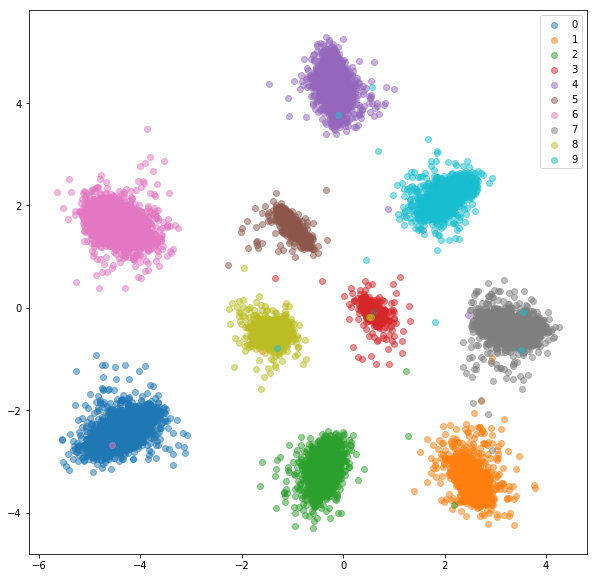

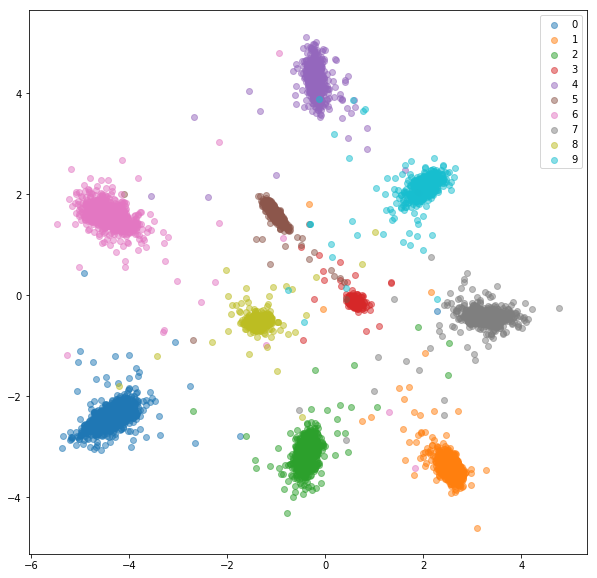

In [20]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

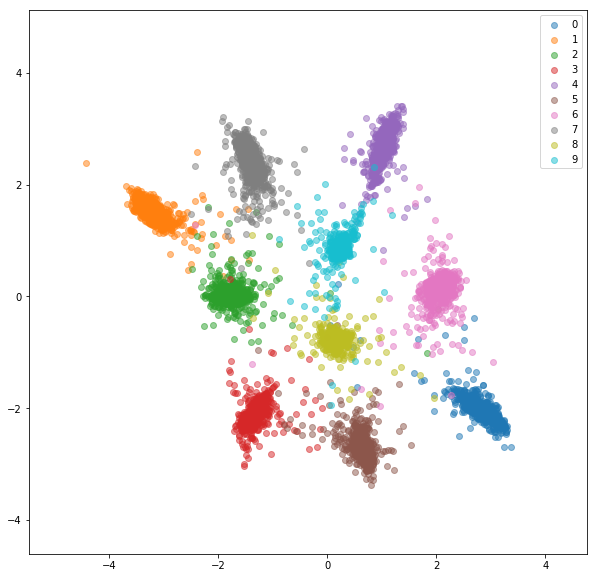

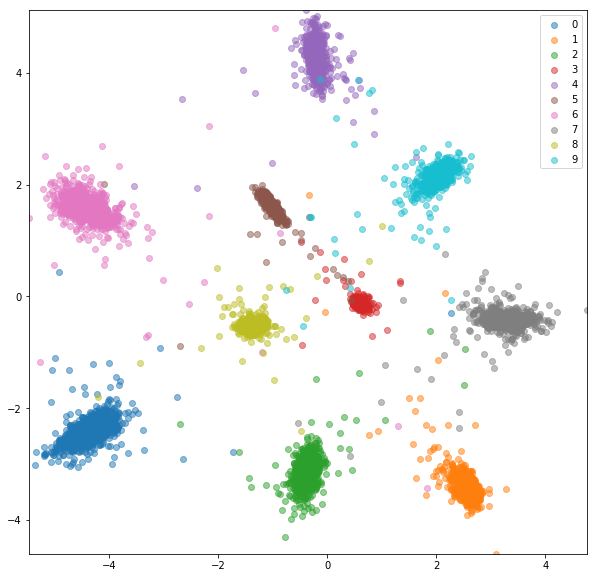

In [21]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

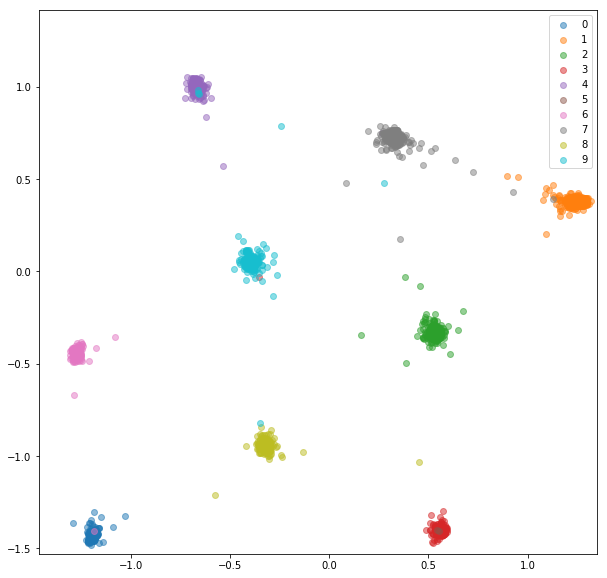

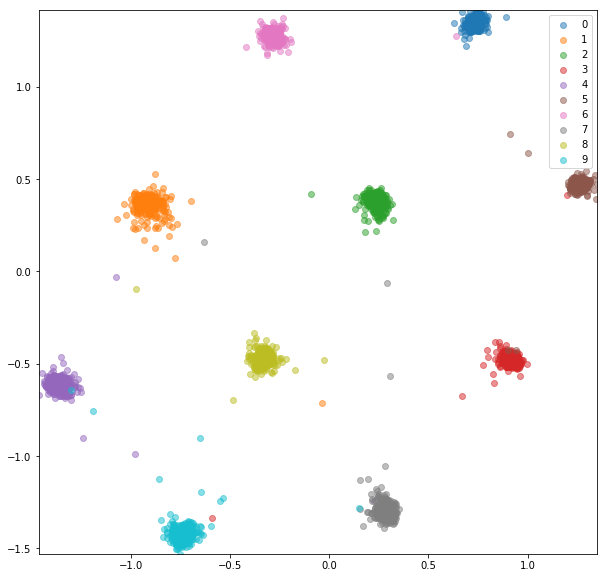

In [22]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)